# Installing dependencies

In [ ]:
! pip install spacy
! pip install langdetect
! python -m spacy download uk_core_news_sm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-05-14 13:40:37.006624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 13:40:39.309395: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 41.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('uk_core_news_sm')


# Imports

In [ ]:
from collections import defaultdict
from typing import List, Tuple
from types import SimpleNamespace
from tqdm import tqdm
import random


from google.colab import drive
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import spacy
from spacy.util import minibatch, compounding
from spacy.training import Example
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Mount gdrive

In [ ]:
drive.mount('/content/gdrive')
! ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	sample_data


# CFG

In [ ]:
path_cfg = SimpleNamespace(
    to_users_data="gdrive/MyDrive/DS/data/Data.xlsx",
)

data_cfg = SimpleNamespace(
    train_size=.64,
    val_size=.16,
    test_size=.2,
    random_state=11,
)

model_cfg = SimpleNamespace(
    seed=10,
)

CFG = SimpleNamespace(
    model=model_cfg,
    data=data_cfg,
    path=path_cfg,
)

print(dir(CFG))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'data', 'model', 'path']


# Load data

In [ ]:
data = pd.read_excel(CFG.path.to_users_data)

print(data.shape)
data.head()

(7380, 3)


,Номенклатура товарів/послуг,ТМ,Категорія
0,"GALAX Рідке мило антибактеріальне ""Класичне"" 1...",GALAX,Рідке мило
1,PW DE LUXE Гель для прання кольорових речей 4000г,POWER DE LUXE,Гель для прання
2,"GALAX Рідке мило ""Чорна орхідея"" 1500г (DOYPACK)",GALAX,Рідке мило
3,"GALAX Рідке мило ""Чорна орхідея"" 500г",GALAX,Рідке мило
4,"GALAX Рідке мило антибактеріальне ""Класичне"" 500г",GALAX,Рідке мило


# Intresting dependencies

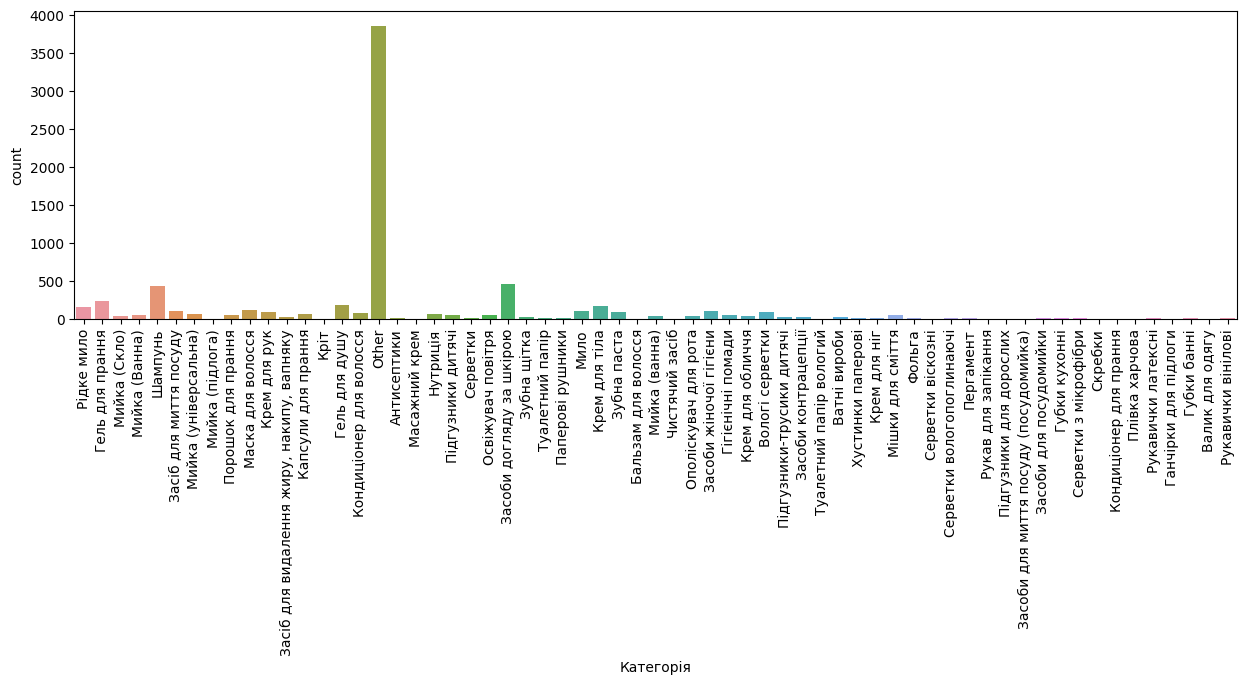

In [ ]:
plt.figure(figsize=(15, 4))
sns.countplot(x=data["Категорія"])
plt.xticks(rotation=90);

In [ ]:
data.groupby("Категорія", as_index=False).agg({"ТМ": "count"}).sort_values("ТМ", ascending=False).T

,0,14,62,8,7,27,51,30,36,18,...,34,61,2,56,46,12,3,58,6,29
Категорія,Other,Засоби догляду за шкірою,Шампунь,Гель для прання,Гель для душу,Крем для тіла,Рідке мило,Маска для волосся,Мило,Засіб для миття посуду,...,Мийка (підлога),Чистячий засіб,Бальзам для волосся,Скребки,Підгузники для дорослих,Засоби для миття посуду (посудомийка),Валик для одягу,Туалетний папір вологий,Ганчірки для підлоги,Масажний крем
ТМ,3864,461,436,243,184,176,164,116,107,105,...,5,4,4,4,3,3,2,1,1,1


In [ ]:
condition = data.groupby("Категорія", as_index=False).agg({"ТМ": "count"}).sort_values("ТМ", ascending=False).query("ТМ < 2")
condition

,Категорія,ТМ
58,Туалетний папір вологий,1
6,Ганчірки для підлоги,1
29,Масажний крем,1


In [ ]:
replacement_value = "Other"
for index, row in condition.iterrows():
    category = row["Категорія"]
    data.loc[data["Категорія"] == category, "Категорія"] = replacement_value

# Split Data

In [ ]:
train_data, test_data = train_test_split(data, test_size=CFG.data.test_size, stratify=data["Категорія"], random_state=CFG.data.random_state)  # using stratified sampling
train_data, val_data = train_test_split(train_data, test_size=CFG.data.test_size, stratify=train_data["Категорія"], random_state=CFG.data.random_state)

In [ ]:
total_samples = len(data)
train_samples = len(train_data)
val_samples = len(val_data)
test_samples = len(test_data)

train_percent = (train_samples / total_samples) * 100
val_percent = (val_samples / total_samples) * 100
test_percent = (test_samples / total_samples) * 100

print("Train data size:", train_samples, "({:.2f}%)".format(train_percent))
print("Validation data size:", val_samples, "({:.2f}%)".format(val_percent))
print("Test data size:", test_samples, "({:.2f}%)".format(test_percent))

Train data size: 4723 (64.00%)
Validation data size: 1181 (16.00%)
Test data size: 1476 (20.00%)


# Preprocessing Data

In [ ]:
def convert_dataframe_to_training_data(df: pd.DataFrame, text_column: str, label_column: str) -> List[Tuple[str, dict]]:
    """
    Converts a DataFrame into training data format for named entity recognition (NER) using spaCy.

    Args:
        df (pd.DataFrame): The input DataFrame.
        text_column (str): The column name containing the text data.
        label_column (str): The column name containing the label data.

    Returns:
        List[Tuple[str, dict]]: The training data in the format of a list of tuples, where each tuple contains
        the text and the annotation dictionary.

    """
    training_data = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        text = row[text_column]
        label = row[label_column]

        entities = []
        start = 0
        while True:
            start = text.find(label, start)
            if start == -1:
                break
            end = start + len(label)
            entities.append((start, end, "PRODUCT"))
            start = end

        training_data.append((text, {"entities": entities}))

    return training_data

In [ ]:
text_column = "Номенклатура товарів/послуг"
tm_column = "ТМ"

training_data_preprocessing, validation_data_preprocessing  = [convert_dataframe_to_training_data(df, text_column, tm_column) for df in (train_data, val_data)]

100%|██████████| 1181/1181 [00:00<00:00, 20026.82it/s]


# Train

In [ ]:
def train_ner_model(training_data: List[Tuple[str, dict]], validation_data: List[Tuple[str, dict]], iterations: int) -> spacy.language.Language:
    """
    Train a Named Entity Recognition (NER) model using training data and validate it using validation data.

    Args:
        training_data (List[Tuple[str, dict]]): Training data as a list of tuples containing text and annotations.
        validation_data (List[Tuple[str, dict]]): Validation data as a list of tuples containing text and annotations.
        iterations (int): Number of training iterations.

    Returns:
        spacy.language.Language: Trained NER model.

    """
    nlp = spacy.load("uk_core_news_sm")
    ner = nlp.get_pipe("ner")

    # Add a new entity label "PRODUCT"
    ner.add_label("PRODUCT")

    # Prepare training data in Example format
    train_examples = []
    for text, annotations in training_data:
        train_examples.append(spacy.training.Example.from_dict(nlp.make_doc(text), annotations))

    # Prepare validation data in Example format
    validation_examples = []
    for text, annotations in validation_data:
        validation_examples.append(spacy.training.Example.from_dict(nlp.make_doc(text), annotations))

    history = {
        "train": {
            "loss": [],
        },
        "val": {
            "loss": [],
        },
    }

    # Train the model
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):
        optimizer = nlp.initialize()
        for i in range(iterations):
            # Train on the training data
            train_losses = {}
            random.shuffle(train_examples)
            train_batches = minibatch(train_examples, size=compounding(4.0, 32.0, 1.001))
            for batch in train_batches:
                nlp.update(batch, drop=0.2, sgd=optimizer, losses=train_losses)
            history["train"]["loss"].append(train_losses["ner"])

            # Update on the validation data
            validation_losses = {}
            for example in validation_examples:
                nlp.update([example], drop=0.0, losses=validation_losses)
            history["val"]["loss"].append(train_losses["ner"])

            print("Iteration:", i)
            print("Train Loss:", train_losses)
            print("Validation Loss:", validation_losses)

    return nlp, history

In [ ]:
# ner_model, train_losses, val_losses, f1_scores = train_ner_model(training_data_preprocessing, validation_data_preprocessing, iterations=5)
ner_model, history = train_ner_model(training_data_preprocessing, validation_data_preprocessing, iterations=5)

Iteration: 0
Train Loss: {'ner': 1154.9348037194393}
Validation Loss: {'ner': 50.47027292860906}
Iteration: 1
Train Loss: {'ner': 182.9937691772735}
Validation Loss: {'ner': 32.738781867020684}
Iteration: 2
Train Loss: {'ner': 88.75964688888958}
Validation Loss: {'ner': 14.851177969645722}
Iteration: 3
Train Loss: {'ner': 92.34851309342665}
Validation Loss: {'ner': 8.803925992588521}
Iteration: 4
Train Loss: {'ner': 66.5765388050275}
Validation Loss: {'ner': 23.33322660979183}


Text(0.5, 1.0, 'Loss')

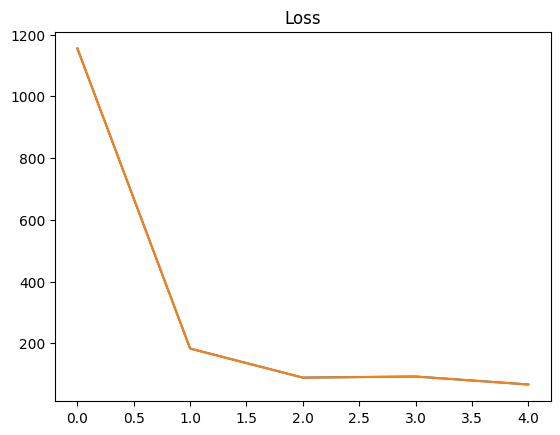

In [ ]:
plt.plot(list(range(len(history['train']["loss"]))), history['train']["loss"])
plt.plot(list(range(len(history['val']["loss"]))), history['val']["loss"])

plt.title("Loss")

# Inference

In [ ]:
for text in list(test_data.sample(15)["Номенклатура товарів/послуг"]):
      doc = ner_model(text)
      print("Text:", text)
      print("Entities:")
      for ent in doc.ents:
        if ent.label_ == "PRODUCT":
          print("  -", ent.text)

Text: Домашній доктор набір крем 30 мл+мило спеціальне 70 г 12+12 шт
Entities:
  - Домашній доктор
Text: Color Naturals стійка фарба інтенсивне живлення для волосся тон 8N
Entities:
  - Color Naturals
Text: Huggies підгузки ultra comfort mega 3 80x2 для хлопчиків
Entities:
  - Huggies
Text: Біокон Шампунь Сила Волосся Об'єм + Відновлення, 215 мл
Entities:
  - Біокон
Text: BIC олівці kids evolution блок 8 шт
Entities:
  - BIC
Text: БОНУС шкребок кухонний металевий
Entities:
Text: La Rive жіночий дезодорант deo in woman red 150 мл
Entities:
  - La Rive
Text: GALAX das POWER-CLEAN Засіб для миття ванної кімнати та сантехніки 500г
Entities:
  - GALAX
Text: Автошини 205/75R16С 110/108R ICE BLAZER WST1 SAILUN
Entities:
Text: Чай цейлонський чорний байховий дрібнолистовий Традиційний150гр.х16п «Принцеса Канді»
Entities:
Text: Revitalift Філлер сировотка антивікова з гіалуроновою кислотою, що заповнює зморшки для шкіри обличчя 30 мл
Entities:
  - Revitalift
Text: Maybelline Superstay 24h стійк